# Assignment 1 — Lars van den Heuvel  
### *Exploring Real-World Networks*

---

**Course:** Model Based Decisions (2025) — *MSc Complex Systems & Policy*  
**Lecturer:** Michael Lees  

---

**Datacollectors & Credits:**  
>J. Leskovec, D. Huttenlocher, J. Kleinberg. *Signed Networks in Social Media.* CHI 2010.  
>J. Leskovec, D. Huttenlocher, J. Kleinberg. *Predicting Positive and Negative Links in Online Social Networks.* WWW 2010.

>Link to website:https://snap.stanford.edu/data/wiki-Vote.html



In [87]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import gzip
def load_adminship_data(filepath):
    print("Loading Wikipedia adminship election data...")
#making a dictionary to link usernames to nodes
    edges = []
    id_to_username = {}
    current_candidate = None
    current_candidate_name = None

#needed to parse through the candidates U, nominators N, and voters V in this way since the build up of the dataset
    with gzip.open(filepath, 'rt', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue

            parts = line.split('\t')

            if parts[0] == 'U' and len(parts) >= 3:
                current_candidate = parts[1]
                current_candidate_name = parts[2]
                id_to_username[current_candidate] = current_candidate_name

            elif parts[0] == 'N' and len(parts) >= 3:
                nom_id = parts[1]
                nom_name = parts[2]
                id_to_username[nom_id] = nom_name

            elif parts[0] == 'V' and current_candidate and len(parts) >= 5:
                vote = int(parts[1])
                voter_id = parts[2]
                voter_name = parts[4]
                id_to_username[voter_id] = voter_name
                edges.append((voter_id, current_candidate, {'vote': vote}))

    print(f"Parsed {len(edges)} edges.")
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # usernames for semantic meaning later on (previously had Node2545 for example)
    for node_id, name in id_to_username.items():
        if node_id in G:
            G.nodes[node_id]['username'] = name

    print(f"Loaded network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G, id_to_username




In [88]:
# -------------------------------------------------------------
# Compute summary statistics
# -------------------------------------------------------------
def network_summary(G):
    print("\n" + "="*60)
    print("NETWORK SUMMARY")
    print("="*60)

    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Directed: {G.is_directed()}")

    # Largest weakly connected component
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    Gcc = G.subgraph(largest_cc).copy()
    print(f"Largest component: {Gcc.number_of_nodes()} nodes, {Gcc.number_of_edges()} edges")

    density = nx.density(Gcc)
    clustering = nx.average_clustering(Gcc.to_undirected())
    assort = nx.degree_assortativity_coefficient(Gcc.to_undirected())
    print(f"Density: {density:.6f}")
    print(f"Average clustering coefficient: {clustering:.4f}")
    print(f"Assortativity: {assort:.3f}")

    try:
        apl = nx.average_shortest_path_length(Gcc.to_undirected())
        print(f"Average shortest path length: {apl:.2f}")
    except Exception as e:
        print(f"Could not compute path length: {e}")

In [89]:
# -------------------------------------------------------------
# Degree distribution (NORMALIZED)
# -------------------------------------------------------------
def plot_degree_distribution(G):
    print("Plotting normalized degree distribution...")
    degrees = [G.degree(n) for n in G.nodes()]
    degree_counts = Counter(degrees)
    
    # ---- DIT IS DE NORMALISATIE STAP ----
    n_nodes = G.number_of_nodes()
    # Bereken de kans P(k) in plaats van de ruwe telling
    probabilities = {k: v / n_nodes for k, v in degree_counts.items()}
    # ----------------------------------------

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    # Plot de kansen (probabilities) in plaats van de tellingen (degree_counts)
    plt.bar(probabilities.keys(), probabilities.values(), color='skyblue', edgecolor='black')
    plt.xlabel("Degree (k)")
    plt.ylabel("Probability P(k)") # Y-as is nu een kans
    plt.title("Degree Distribution (Linear)")
 
     # Aangepaste limieten voor een kansverdeling
    plt.xlim(0, 300) 
    # plt.ylim(0, 2000) # Deze regel verwijderen, kansen zijn klein (tussen 0 en 1)

    plt.subplot(1,2,2)
    # Plot de kansen (probabilities) in plaats van de tellingen (degree_counts)
    plt.loglog(list(probabilities.keys()), list(probabilities.values()), 'bo', alpha=0.7)
    plt.xlabel("Degree (k) (log)")
    plt.ylabel("Probability P(k) (log)") # Y-as is nu een kans
    plt.title("Degree Distribution (Log-Log)")

    plt.tight_layout()
    plt.show()

    print(f"Mean degree: {np.mean(degrees):.2f}")
    print(f"Max degree: {max(degrees)}")

In [90]:
#----- --------------------------------------------------------
# Centrality measures
# -------------------------------------------------------------
def calculate_centrality_measures(G):
    print("\nCalculating centrality measures...")
    centralities = {}

    # Convert to largest component
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    Gcc = G.subgraph(largest_cc).copy()

# sampling for betweeenness like suggested in class, I took 1000 like mentioned 
    centralities['degree'] = nx.degree_centrality(Gcc)
    centralities['betweenness'] = nx.betweenness_centrality(Gcc, k=1000)  
    centralities['closeness'] = nx.closeness_centrality(Gcc)
    try:
        centralities['eigenvector'] = nx.eigenvector_centrality(Gcc.to_undirected(), max_iter=1000)
    except nx.PowerIterationFailedConvergence:
        print("Eigenvector centrality failed to converge; using PageRank instead")
        centralities['eigenvector'] = nx.pagerank(Gcc)

    return centralities

def display_top_nodes(centralities, id_to_username, top_n=10):
    print("\n" + "="*60)
    print(f"TOP {top_n} USERS BY CENTRALITY")
    print("="*60)
    for measure, values in centralities.items():
        top_nodes = sorted(values.items(), key=lambda x: x[1], reverse=True)[:top_n]
        print(f"\n{measure.upper()} CENTRALITY")
        print("-"*40)
        for i, (node, val) in enumerate(top_nodes, 1):
            username = id_to_username.get(node, f"Node {node}")
            print(f"{i:2d}. {username} (ID {node}) - {val:.6f}")

In [91]:

#the three classical models retrieved and adapted from the network_visualization_suite.py (NORMALIZED)

import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

def compare_with_models(graph):
    models = {
        "Random": nx.erdos_renyi_graph,
        "Small-World": nx.watts_strogatz_graph,
        "Scale-Free": nx.barabasi_albert_graph
    }

    # Print tabelkop
    print("Network\t\tClustering\tPath Length")
    print("-----------------------------------------")

    # Bereken eerst de statistieken voor het ECHTE netwerk
    # Converteer naar ongericht voor een eerlijke vergelijking van C en L
    G_real_undirected = graph.to_undirected()
    largest_cc_real = max(nx.connected_components(G_real_undirected), key=len)
    subgraph_real = G_real_undirected.subgraph(largest_cc_real)

    C_real = nx.average_clustering(subgraph_real)
    L_real = nx.average_shortest_path_length(subgraph_real)
    print(f"REAL DATA\t{C_real:.4f}\t\t{L_real:.2f}")

    # Loop door de modellen
    for name, model_func in models.items():
        n = graph.number_of_nodes()

        if name == "Random":
            m = graph.number_of_edges()
            p = 2 * m / (n * (n - 1))
            G_model = model_func(n, p)
        elif name == "Small-World":
            k = int(sum(dict(graph.degree()).values()) / n)
            G_model = model_func(n, k, 0.1)
        else:
            m_ba = int(sum(dict(graph.degree()).values()) / (2 * n))
            # Zorg dat m_ba minimaal 1 is, anders mislukt Barabasi-Albert
            G_model = model_func(n, max(1, m_ba))

        G_model_undirected = G_model  # Modellen zijn al ongericht

        if nx.is_connected(G_model_undirected):
            subgraph = G_model_undirected
        else:
            largest_cc = max(nx.connected_components(G_model_undirected), key=len)
            subgraph = G_model_undirected.subgraph(largest_cc)

        # Voorkom fouten als het subgraph leeg of te klein is
        if subgraph.number_of_nodes() > 1:
            L = nx.average_shortest_path_length(subgraph)
            C = nx.average_clustering(G_model)  # Clustering kan op het hele model
        else:
            L = 0
            C = 0

        print(f"{name:8s}\t{C:.4f}\t\t{L:.2f}")

        # --- NORMALISATIE STAP VOOR MODEL PLOTS ---
        degrees = [d for _, d in G_model.degree()]
        degree_counts = Counter(degrees)
        n_model_nodes = G_model.number_of_nodes()

        # Voorkom delen door nul als het model leeg is
        if n_model_nodes > 0:
            probabilities = {k: v / n_model_nodes for k, v in degree_counts.items()}
        else:
            probabilities = {}

        plt.figure()
        # Plot de kansen (probabilities) in plaats van de tellingen (degrees)
        plt.hist(
            degrees,
            bins=range(min(degrees, default=0), max(degrees, default=1) + 2),
            edgecolor='black',
            align='left',
            density=True  # density=True doet normalisatie!
        )
        plt.title(f"Degree Distribution (Normalized): {name}")
        plt.xlabel("Degree (k)")
        plt.ylabel("Probability P(k)")  # Y-as is nu een kans

        # Optioneel: zet de log-log schaal aan om de vorm beter te zien
        plt.yscale('log')
        plt.xscale('log')

        plt.show()

Loading Wikipedia adminship election data...
Parsed 114040 edges.
Loaded network with 7194 nodes and 110087 edges.

NETWORK SUMMARY
Number of nodes: 7194
Number of edges: 110087
Directed: True
Largest component: 7136 nodes, 110053 edges
Density: 0.002161
Average clustering coefficient: 0.1484
Assortativity: -0.087
Average shortest path length: 3.23
Plotting normalized degree distribution...


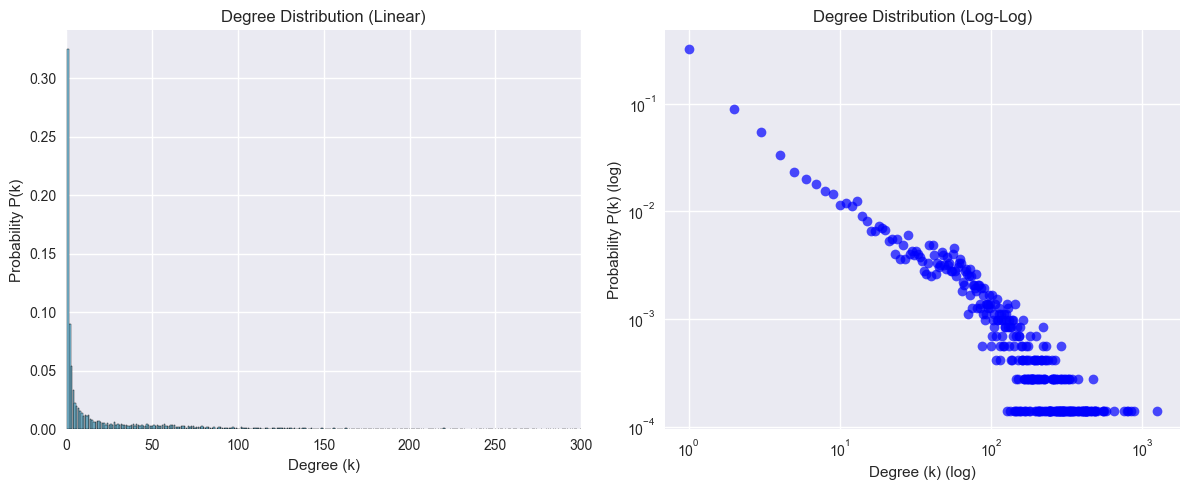

Mean degree: 30.61
Max degree: 1243

Calculating centrality measures...

TOP 10 USERS BY CENTRALITY

DEGREE CENTRALITY
----------------------------------------
 1. siva1979 (ID 2565) - 0.174212
 2. jaranda (ID 1549) - 0.123896
 3. mailer (ID 766) - 0.117169
 4. merovingian (ID 11) - 0.112404
 5. the (ID 457) - 0.110722
 6. xoloz (ID 1166) - 0.105676
 7. terence (ID 2688) - 0.091100
 8. neil (ID 1374) - 0.080168
 9. mongo (ID 1151) - 0.078206
10. acalamari (ID 5524) - 0.077085

BETWEENNESS CENTRALITY
----------------------------------------
 1. siva1979 (ID 2565) - 0.018640
 2. jaranda (ID 1549) - 0.017054
 3. danny (ID 15) - 0.012220
 4. everyking (ID 72) - 0.008081
 5. daniel (ID 737) - 0.006328
 6. xoloz (ID 1166) - 0.005526
 7. majorly (ID 5079) - 0.005468
 8. phaedriel (ID 2328) - 0.004902
 9. neutrality (ID 28) - 0.004785
10. newyorkbrad (ID 3456) - 0.004327

CLOSENESS CENTRALITY
----------------------------------------
 1. elonka (ID 4037) - 0.301534
 2. danny (ID 15) - 0.295761


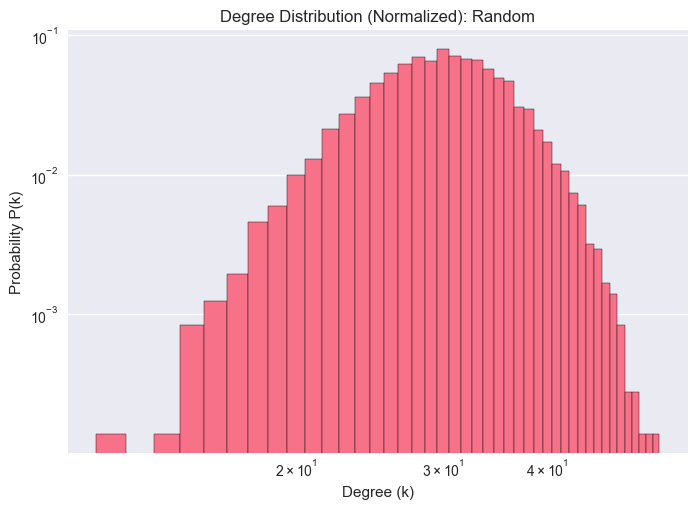

Small-World	0.5247		3.61


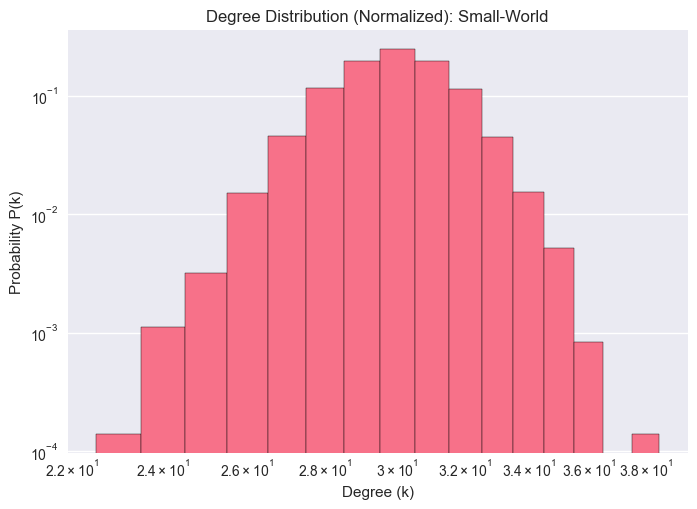

Scale-Free	0.0188		2.80


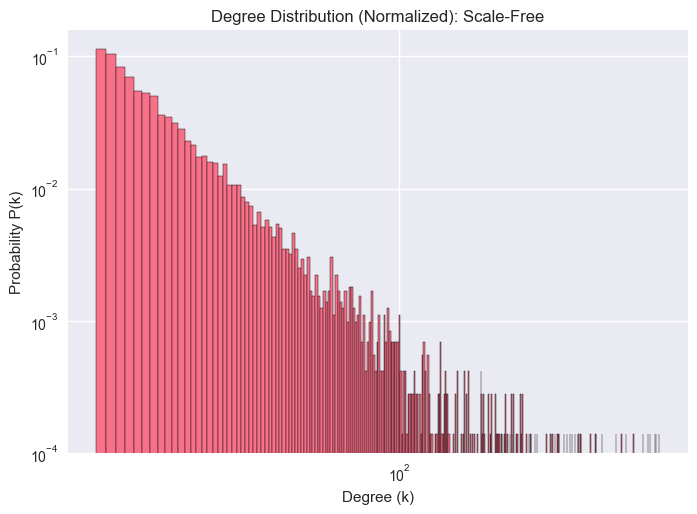

In [92]:
def main():
    file = "C:/Users/lars_/MBDM/Week 2 - Networks/datasets/wikiElec.ElecBs3.txt.gz"
    G, id_to_username = load_adminship_data(file)
    network_summary(G)
    plot_degree_distribution(G)
    centr = calculate_centrality_measures(G)
    display_top_nodes(centr, id_to_username)
    compare_with_models(G)

if __name__ == "__main__":
    main()
